In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.ndimage as scim
import seaborn as sns

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8), cmap="gray")
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

<a href="https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf">link</a>

### LoG and DoG

#### Laplacian of Gaussian

Let $G$ be the Gaussian function, $G = (2\pi\sigma^2)^{-1} \exp(-\frac{x^2+y^2}{2\sigma^2})$

$$\begin{align}
\frac{\partial G}{\partial x} & (2\pi\sigma^2)^{-1}  \exp(-\frac{x^2+y^2}{2\sigma^2}) \frac{-x}{\sigma^2}\\
\frac{\partial^2G}{\partial x^2} &= (2\pi\sigma^2)^{-1} \big[\exp(-\frac{x^2+y^2}{2\sigma^2})\frac{-x^2}{\sigma^4} + \exp(-\frac{x^2+y^2}{2\sigma^2})\frac{-1}{\sigma^2}\big] \\
&= (2\pi\sigma^2)^{-1} \frac{x^2 - \sigma^2}{\sigma^4} \exp(-\frac{x^2+y^2}{2\sigma^2})\\
\nabla^2 G &= \frac{\partial^2G}{\partial x^2} + \frac{\partial^2G}{\partial y^2} \\
&= (2\pi\sigma^2)^{-1} \frac{x^2 - 2\sigma^2 + y^2}{\sigma^4} \exp(-\frac{x^2+y^2}{2\sigma^2})
\end{align}$$

#### Difference of Gaussian
$$\begin{align}
\frac{\partial G}{\partial \sigma} &= \frac{-1}{\pi\sigma^3}\exp(-\frac{x^2+y^2}{2\sigma^2}) + \frac{1}{2\pi\sigma^2}\exp(-\frac{x^2+y^2}{2\sigma^2})\frac{x^2+y^2}{\sigma^3} \\
&= (2\pi\sigma^2)^{-1}\exp(-\frac{x^2+y^2}{2\sigma^2})(\frac{x^2+y^2}{\sigma^3}-\frac{2\sigma^2}{\sigma^3})\\
&= (2\pi\sigma^2)^{-1}\exp(-\frac{x^2+y^2}{2\sigma^2})(\frac{x^2+y^2}{\sigma^4}-\frac{2\sigma^2}{\sigma^4})\sigma\\
&= \sigma\nabla^2G
\end{align}$$
By the limit definition of derivative,
$$\frac{\partial G}{\partial \sigma} = \lim_{h\rightarrow 0} \frac{G(x,y, \sigma+h) - G(x, y,\sigma)}{h}\approx lim_{k\rightarrow 1} \frac{G(x,y, k\sigma) - G(x, y,\sigma)}{(k-1)\sigma}$$
So that $$DoG := G(x,y, k\sigma) - G(x, y,\sigma) \approx (k-1)\sigma\sigma \nabla^2G = (k-1)\sigma^2 \nabla^2G$$

### Scale-space extrema (Octave)
To identify locations and scales that can be repeatably assigned under differing views of the same object. 

#### Constructing octave
Generate $m$ octaves (or image pyramids), each with $n$ different blurring scale ($k^1\sigma, ..., k^n\sigma$). Generally, we choose $k = 2^{1/s}, s\in\mathbb Z$, and each octave contains $s+3$ scales, i.e. $2^{1/s}, 2^{2/s},...2^{1+3/s}$. Then, for the next level of the octave, down-sample from the one with $2\sigma$, then keep do the next. 

__Example__ If $s = 2$, i.e. $k = \sqrt{2}$

|       | scale1 | scale2 | scale3 | scale4 | scale5 |
|---    |---     | ---    | ---    | ---    |---     |
|octave1|$\sqrt{2}$| $2$ | $2\sqrt{2}$| $4$ | $4\sqrt{2}$|
|octave2|$2\sqrt{2}$| $4$ | $4\sqrt{2}$| $8$ | $8\sqrt{2}$|
|octave3|$4\sqrt{2}$| $8$ | $8\sqrt{2}$| $16$ | $16\sqrt{2}$|
|octave4|$8\sqrt{2}$| $16$ | $16\sqrt{2}$| $32$ | $32\sqrt{2}$|

#### Taking DoG
Then, for each octave, take DoG by taking the difference between adjacent scales. Note that $k$ is unchanged for each DoG

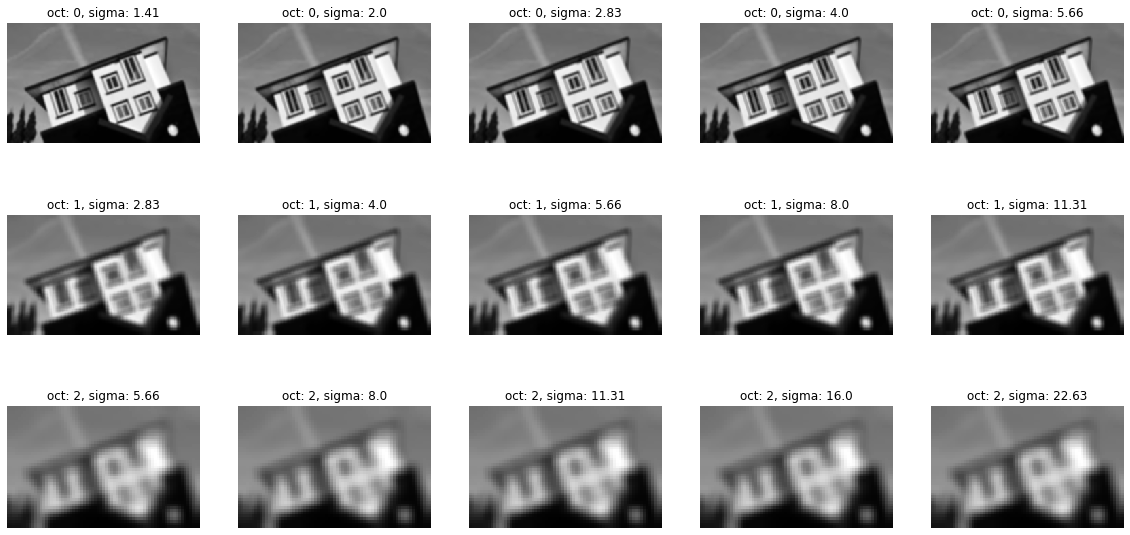

In [58]:
img = cv2.imread("../assets/Window2.jpg", cv2.IMREAD_GRAYSCALE)
num_octave, s = 3, 2
fig, axs = plt.subplots(num_octave, s+3, figsize=(20, 10))
img_sets = []
for octave in range(num_octave):
    img_sets.append([])
    if octave > 0:
        img = img_sets[octave - 1][0][::2, ::2]
    for scale in range(s + 3):
        sigma = 2**(octave) * 2 ** ((1+scale)/s)
        img_sets[octave].append(cv2.GaussianBlur(img, (5, 5), sigma))
        imshow(img_sets[octave][scale], axs[octave][scale], 
               title="oct: " + str(octave) + ", sigma: " + str(round(sigma, 2)), bgr=False)

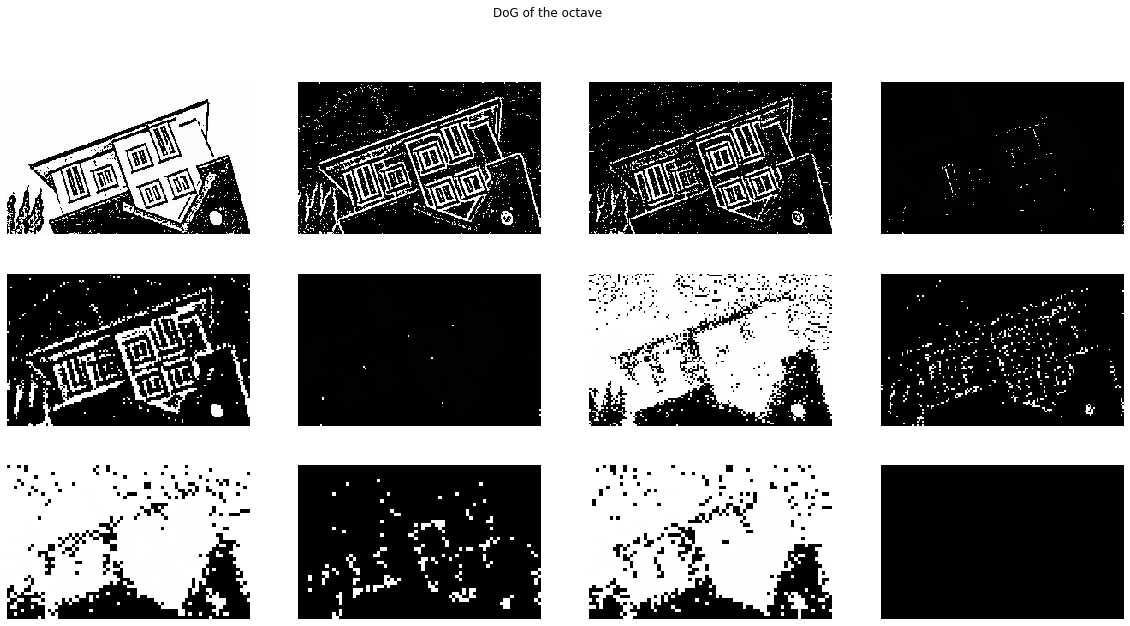

In [62]:
DoG = []
fig, axs = plt.subplots(num_octave, s+2, figsize=(20, 10))
for octave in range(num_octave):
    DoG.append([])
    for scale in range(s + 2):
        DoG[octave].append(img_sets[octave][scale+1].astype(int) - img_sets[octave][scale].astype(int))
        imshow(DoG[octave][scale], axs[octave][scale], bgr=False)
fig.suptitle("DoG of the octave");